<a href="https://colab.research.google.com/github/abhishekunique/zurich-ss/blob/main/Brax_PG_Fast_Zurich_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Brax and some helper modules
from IPython.display import clear_output

import collections
from datetime import datetime
import functools
import math
import time
from typing import Any, Callable, Dict, Optional, Sequence, List

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax.envs import to_torch
from brax.io import metrics
from brax.training.agents.ppo import train as ppo
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# have torch allocate on device first, to prevent JAX from swallowing up all the
# GPU memory. By default JAX will pre-allocate 90% of the available GPU memory:
# https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
v = torch.ones(1, device='cuda')

Here is a REINFORCE agent

In [2]:
class REINFORCEAgent(nn.Module):

  def __init__(self,
               policy_layers: Sequence[int],
               value_layers: Sequence[int],
               discount: float, 
               entropy_weight: float,
               device: str):
    super(REINFORCEAgent, self).__init__()

    policy = []
    for w1, w2 in zip(policy_layers, policy_layers[1:]):
      policy.append(nn.Linear(w1, w2))
      policy.append(nn.SiLU())
    policy.pop()  # drop the final activation
    self.policy = nn.Sequential(*policy)

    value = []
    for w1, w2 in zip(value_layers, value_layers[1:]):
      value.append(nn.Linear(w1, w2))
      value.append(nn.SiLU())
    value.pop()  # drop the final activation
    self.value = nn.Sequential(*value)
    self.discount = discount 
    self.entropy_weight = entropy_weight
    self.device = device

  @torch.jit.export
  def dist_create(self, logits):
    """Normal followed by tanh.

    torch.distribution doesn't work with torch.jit, so we roll our own."""
    loc, scale = torch.split(logits, logits.shape[-1] // 2, dim=-1)
    scale = F.softplus(scale) + .001
    return loc, scale

  @torch.jit.export
  def dist_sample_no_postprocess(self, loc, scale):
    return torch.normal(loc, scale)

  @torch.jit.export
  def dist_entropy(self, loc, scale):
    log_normalized = 0.5 * math.log(2 * math.pi) + torch.log(scale)
    entropy = 0.5 + log_normalized
    entropy = entropy * torch.ones_like(loc)
    return entropy.sum(dim=-1)

  @torch.jit.export
  def dist_log_prob(self, loc, scale, dist):
    log_unnormalized = -0.5 * ((dist - loc) / scale).square()
    log_normalized = 0.5 * math.log(2 * math.pi) + torch.log(scale)
    log_prob = log_unnormalized - log_normalized
    return log_prob.sum(dim=-1)

  @torch.jit.export
  def get_logits_action(self, observation):
    logits = self.policy(observation)
    loc, scale = self.dist_create(logits)
    action = self.dist_sample_no_postprocess(loc, scale)
    entropy = self.dist_entropy(loc,  scale)
    log_prob = self.dist_log_prob(loc,  scale, action)
    return logits, action, entropy, log_prob

  @torch.jit.export
  def update_parameters(self, sample_trajs: List[torch.Tensor]):
      states = sample_trajs[0]
      actions = sample_trajs[1]
      rewards = sample_trajs[2]
      entropies = sample_trajs[3]
      log_probs = sample_trajs[4]
    
      # Bookkeeping
      R_EPS = 1e-9
      R = torch.zeros(rewards.shape[0],rewards.shape[1]).cuda()
      running_r = torch.zeros(rewards.shape[0],).cuda()
      baseline_losses = torch.zeros(rewards.shape[1],).cuda()
      
      # Compute discounted cumulative sum TODO: Check this
      for j in range(rewards.shape[1]):
          i = rewards.shape[1] - 1 - j
          running_r = self.discount * running_r + rewards[:, i]
          baseline_rpred = self.value(states[:, i])[:, 0]
          R[:, i] = running_r - baseline_rpred # Subtract the baseline
          baseline_loss = torch.sum((baseline_rpred - running_r)**2)
          baseline_losses[i] = baseline_loss
          
      # Normalize advantages
      R_mean = torch.mean(R)
      R_std = torch.std(R)
      R = (R - R_mean) / (R_std + R_EPS)
      
      # Compute loss
      loss = -(log_probs*R).sum() - self.entropy_weight*entropies.sum()
      loss = loss / len(rewards)
      baseline_loss = baseline_losses.sum() / len(rewards)
      loss += baseline_loss
      return loss

Finally, some code for unrolling and batching environment data:

In [8]:
def sample_trajectory(agent, env, num_steps):
  """Return step data over multple unrolls."""
  observation = env.reset()
  states = []
  actions = []
  rewards = []
  entropies = []
  log_probs = []
  for _ in range(num_steps):
    logits, action, entropy, log_prob = agent.get_logits_action(observation)
    observation, reward, done, info = env.step(action)
    states.append(observation[None])
    actions.append(action[None])
    rewards.append(reward[None])
    entropies.append(entropy[None])
    log_probs.append(log_prob[None])
  return [torch.transpose(torch.cat(states), 0, 1), 
          torch.transpose(torch.cat(actions), 0, 1),
          torch.transpose(torch.cat(rewards), 0, 1), 
          torch.transpose(torch.cat(entropies), 0, 1),
          torch.transpose(torch.cat(log_probs), 0, 1)]

In [ ]:
def make_env(env_name, num_envs, episode_length, device):
  gym_name = f'brax-{env_name}-v0'
  if gym_name not in gym.envs.registry.env_specs:
    entry_point = functools.partial(envs.create_gym_env, env_name=env_name)
    gym.register(gym_name, entry_point=entry_point)
  env = gym.make(gym_name, batch_size=num_envs, episode_length=episode_length)
  env = to_torch.JaxToTorchWrapper(env, device=device)
  return env

In [ ]:
def train(
    env_name: str = 'reacher',
    num_envs: int = 2048,
    episode_length: int = 100,
    device: str = 'cuda',
    num_epochs: int = 200,
    discount: float = 0.99,
    entropy_weight: float = 0.0001, 
    hidden_size: int = 128,
    learning_rate: float = 3e-4,
):

  # Define environment  
  env = make_env(env_name, num_envs, episode_length, device)
    
  # env warmup
  env.reset()
  action = torch.zeros(env.action_space.shape).to(device)
  env.step(action)

  # create the agent
  policy_layers = [env.observation_space.shape[-1], hidden_size, hidden_size, env.action_space.shape[-1] * 2]
  value_layers = [env.observation_space.shape[-1], hidden_size, hidden_size, 1]
  agent = REINFORCEAgent(policy_layers, value_layers, discount, entropy_weight, device)
  agent = torch.jit.script(agent.to(device))
  optimizer = optim.Adam(agent.parameters())
    
  # Bookkeeping
  returns = []

  # Training loop
  for iter_num in range(num_epochs):
    # Sample trajectories
    sample_trajs = sample_trajectory(agent, env, episode_length)

    loss = agent.update_parameters(sample_trajs)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    rewards_np = sample_trajs[2].cpu().numpy().sum(axis=-1).mean()
    print("Episode: {}, reward: {}".format(iter_num, rewards_np))
    returns.append(rewards_np)

  plt.plot(returns)

Episode: 0, reward: -117.34770202636719
Episode: 1, reward: -113.21853637695312
Episode: 2, reward: -109.62570190429688
Episode: 3, reward: -105.3235092163086
Episode: 4, reward: -101.61454772949219
Episode: 5, reward: -98.49986267089844
Episode: 6, reward: -94.55696105957031
Episode: 7, reward: -90.96101379394531
Episode: 8, reward: -87.97770690917969
Episode: 9, reward: -84.19537353515625
Episode: 10, reward: -80.78797912597656
Episode: 11, reward: -77.3096694946289
Episode: 12, reward: -73.7021484375
Episode: 13, reward: -70.43171691894531
Episode: 14, reward: -66.47065734863281
Episode: 15, reward: -63.09730529785156
Episode: 16, reward: -59.35502624511719
Episode: 17, reward: -55.87764358520508
Episode: 18, reward: -52.15184783935547
Episode: 19, reward: -48.36937713623047
Episode: 20, reward: -44.92522048950195
Episode: 21, reward: -41.5605583190918
Episode: 22, reward: -38.430328369140625
Episode: 23, reward: -35.344635009765625
Episode: 24, reward: -32.98308563232422
Episode: 2

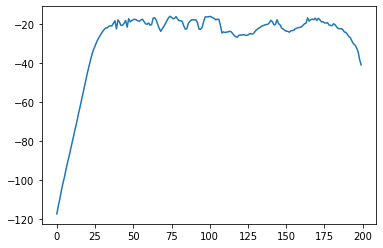

In [9]:
train()